# SurvivalStan

Tutorial: http://www.hammerlab.org/2017/06/26/introducing-survivalstan/

TODO

- [] Plot divergent transitions for different runs with different options
- [] Run model independent of SurvivalStan so that I can reparametrize
- [] Change prior ranges
- [] Reparametrize

## Set up environment

In [2]:
# Install Stan utilities

!rm stan_utility.py
!wget https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py
    

# Upgrade pip
!pip3 install --user --upgrade pip


# Install PyStan
!pip3 install --user pystan


# Install SurvivalStan
!git clone https://github.com/hammerlab/survivalstan.git
!pip3 uninstall --yes survivalstan
!pip3 install --user survivalstan/.

--2019-07-25 13:22:57--  https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.12.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.12.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5593 (5.5K) [text/plain]
Saving to: ‘stan_utility.py’

stan_utility.py     100%[===================>]   5.46K  --.-KB/s    in 0s      

2019-07-25 13:22:58 (146 MB/s) - ‘stan_utility.py’ saved [5593/5593]

Requirement already up-to-date: pip in /home/arnoldp9/.local/lib/python3.6/site-packages (19.2.1)
fatal: destination path 'survivalstan' already exists and is not an empty directory.
Uninstalling survivalstan-0.1.2.8:
  Successfully uninstalled survivalstan-0.1.2.8
Processing ./survivalstan


  Created wheel for survivalstan: filename=survivalstan-0.1.2.8-py2.py3-none-any.whl size=51505 sha256=00a8f5a8944b2a2d4c4e99deb2a841c4f517995c5d1230a407137fabf1734388
  Stored in directory: /tmp/pip-ephem-wheel-cache-a3zxomb2/wheels/14/78/50/ed05ddb3d2941b402a3072e01785737037153416a42ab1bdac
Successfully built survivalstan


In [3]:
import sys
import os

import math

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import pystan
import survivalstan
import stan_utility

## Simple exponential model with covariates

This serves as a simple sanity check.

$S(t) = \exp( -at ) \exp( \beta \cdot X )$

The following prior strategy will be used:

* Priors for established risk factors
* Priors for factor with more uncertain relevance

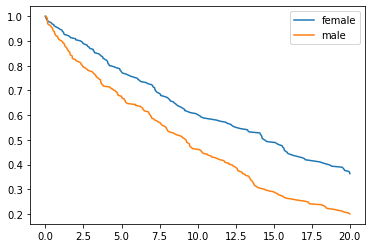

In [4]:
# Simulate Data
df2 = survivalstan.sim.sim_data_exp_correlated(
    N=500, censor_time=20, rate_form='1 + sex', rate_coefs=[-3, 0.5])


survivalstan.utils.plot_observed_survival(
    df2.query('sex == "female"'),
    time_col='t',
    event_col='event',
    label='female')

survivalstan.utils.plot_observed_survival(
    df2.query('sex == "male"'),
    time_col='t',
    event_col='event',
    label='male')

plt.legend()

In [7]:
# Define runs
runs = {'q': [  200, 1,  150, 0.8],
        '1': [ 2000, 4, 1500, 0.8],
        '2': [ 2000, 4, 1500, 0.99],
        '3': [10000, 4, 9000, 0.99] }

In [8]:
# Infer parameters
def infer_params(Niter = 2000, Nchains = 2, Nwarmup = 1500, Nadapt_delta = 0.9):

    ctrl = dict(adapt_delta = Nadapt_delta,
                max_treedepth = 20)

    fit2_org = survivalstan.fit_stan_survival_model(
        df=df2,
        time_col='t',
        event_col='event',
        model_code=survivalstan.models.exp_survival_model,
        formula='~ age + sex',
        model_cohort = 'exp model',
        iter = Niter,
        chains = Nchains,
        warmup = Nwarmup,
        control = ctrl)
    
    return fit2_org


# Plot divergent transitions
def div_trans_beta(fit):
    
    light="#DCBCBC"
    light_highlight="#C79999"
    mid="#B97C7C"
    mid_highlight="#A25050"
    dark="#8F2727"
    dark_highlight="#7C0000"
    green="#00FF00"

    nondiv_params, div_params = stan_utility.partition_div(fit)

    plt.scatter([x[0] for x in nondiv_params['beta']], 
                [x[1] for x in nondiv_params['beta']], \
                 color = mid_highlight, alpha=0.05)
    plt.scatter([x[0] for x in div_params['beta']],
                [x[1] for x in div_params['beta']], \
                 color = green, alpha=0.5)

    plt.gca().set_xlabel("beta_1")
    plt.gca().set_ylabel("beta_2")

    plt.show()
    
    
def div_trans_tau_s(fit):
    
    light="#DCBCBC"
    light_highlight="#C79999"
    mid="#B97C7C"
    mid_highlight="#A25050"
    dark="#8F2727"
    dark_highlight="#7C0000"
    green="#00FF00"

    nondiv_params, div_params = stan_utility.partition_div(fit)

    plt.scatter([x[0] for x in nondiv_params['beta']], 
                np.log(nondiv_params['tau_s_raw']), \
                color = mid_highlight, alpha=0.05)
    
    plt.scatter([x[0] for x in div_params['beta']],
                np.log(div_params['tau_s_raw']), \
                color = green, alpha=0.5)

    plt.gca().set_xlabel("beta_1")
    plt.gca().set_ylabel("log tau_s_raw")

    plt.show()
    
    
def div_trans_alpha(fit):
    
    light="#DCBCBC"
    light_highlight="#C79999"
    mid="#B97C7C"
    mid_highlight="#A25050"
    dark="#8F2727"
    dark_highlight="#7C0000"
    green="#00FF00"

    nondiv_params, div_params = stan_utility.partition_div(fit)

    plt.scatter(nondiv_params['alpha'], 
                np.log(nondiv_params['tau_s_raw']), \
                color = mid_highlight, alpha=0.05)
    
    plt.scatter(div_params['alpha'],
                np.log(div_params['tau_s_raw']), \
                color = green, alpha=0.5)

    plt.gca().set_xlabel("alpha")
    plt.gca().set_ylabel("log tau_s_raw")

    plt.show()
    
    
def plot_div_trans(fit):
    div_trans_beta(fit)
    div_trans_tau_s(fit)
    div_trans_alpha(fit)
    
    
def run_all(key):
    params = runs[key]

    print(params)

    # Fit params
    res = infer_params(Niter = params[0], 
                       Nchains = params[1], 
                       Nwarmup = params[2], 
                       Nadapt_delta = params[3])

    # Show coefs
    coefs = survivalstan.utils.filter_stan_summary([res], pars=['lp__', 
                                                                     'alpha', 
                                                                     'beta', 
                                                                     'tau_s_raw', 
                                                                     'tau_raw'])
    print(coefs)

    # Diagnostics
    pystan.check_hmc_diagnostics(res['fit'])

    # Divergent transitions
    plot_div_trans(res['fit'])

    print("=============================")

[200, 1, 150, 0.8]
Reusing model.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Ran in 1.906 sec.
                   mean   se_mean        sd         2.5%          50%  \
lp__       -1352.401949  0.381938  0.663987 -1353.158667 -1352.394622   
alpha          0.030855  0.000111  0.000277     0.030347     0.030857   
beta[1]        0.347281  0.024308  0.041688     0.311992     0.328496   
beta[2]        0.010657  0.000614  0.001179     0.007804     0.010679   
tau_s_raw      0.911628  0.019318  0.032920     0.881441     0.904651   
tau_raw[1]     0.784226  0.018450  0.031743     0.723993     0.797482   
tau_raw[2]     2.682090  0.054516  0.096729     2.482980     2.657948   

                  97.5%      Rhat  
lp__       -1351.486483  1.915450  
alpha          0.031431  0.992290  
beta[1]        0.427334  1.914017  
beta[2]        0.011739  1.626559  
tau_s_raw      0.976002  1.949549  
tau_raw[1]     0.810549  2.000944  
tau_raw[2]     2.792708  2.001634  


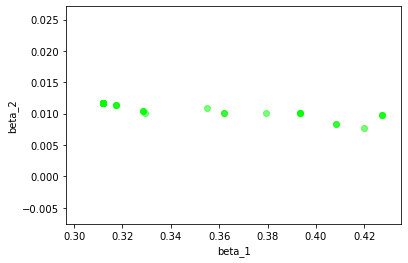

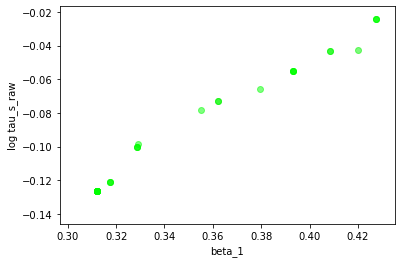

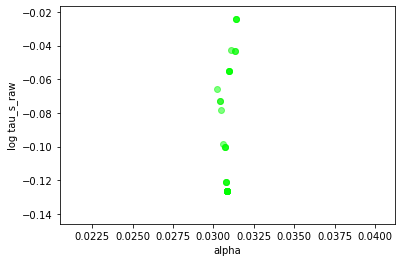

In [9]:
run_all('q')

[2000, 4, 1500, 0.8]
Reusing model.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Ran in 25.474 sec.
                   mean    se_mean           sd         2.5%          50%  \
lp__       -1355.573459   0.182811     2.202183 -1360.610271 -1355.281618   
alpha          0.042996   0.001444     0.018460     0.017779     0.040280   
beta[1]        0.431255   0.003276     0.107142     0.216522     0.432185   
beta[2]        0.004812   0.000476     0.007333    -0.011142     0.004568   
tau_s_raw      0.343408   0.040843     0.335976     0.027396     0.245808   
tau_raw[1]   108.092019  38.566415  1120.504399     0.254168     4.273934   
tau_raw[2]     1.174759   0.124640     2.303868     0.061653     0.550588   

                  97.5%      Rhat  
lp__       -1352.155407  1.037778  
alpha          0.094209  1.021329  
beta[1]        0.643709  1.001406  
beta[2]        0.018885  1.013882  
tau_s_raw      1.219082  1.025419  
tau_raw[1]   539.492308  1.001281  
tau_raw[2]     5.384823  1.006053  


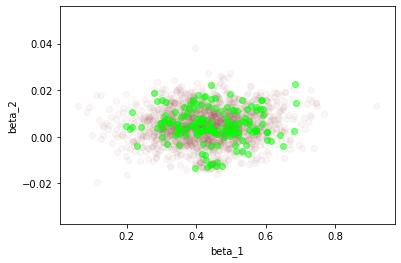

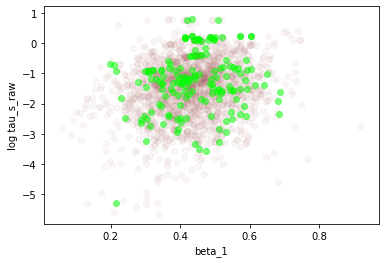

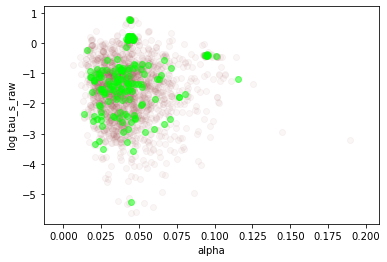

In [10]:
run_all('1')

[2000, 4, 1500, 0.99]
Reusing model.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Ran in 311.277 sec.
                   mean    se_mean           sd         2.5%          50%  \
lp__       -1354.820390   0.196829     2.660888 -1361.173993 -1354.369991   
alpha          0.042161   0.000780     0.018802     0.016278     0.038949   
beta[1]        0.439412   0.003183     0.112676     0.218346     0.440614   
beta[2]        0.005193   0.000301     0.007690    -0.009739     0.005109   
tau_s_raw      0.677324   0.051862     0.920887     0.021946     0.374543   
tau_raw[1]   153.079394  72.530639  2222.449752     0.215417     2.378473   
tau_raw[2]     2.341985   0.395398     8.366747     0.138727     0.684647   

                  97.5%      Rhat  
lp__       -1350.748283  1.017804  
alpha          0.086814  1.002546  
beta[1]        0.656616  1.002403  
beta[2]        0.020532  1.001421  
tau_s_raw      3.276497  1.001143  
tau_raw[1]   592.987664  1.002593  
tau_raw[2]    16.296235  1.002923  


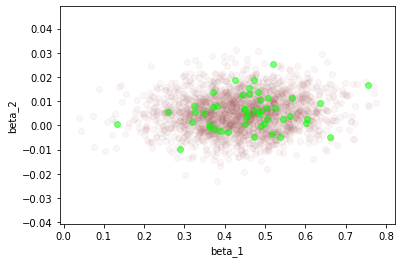

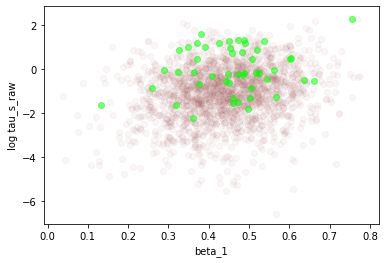

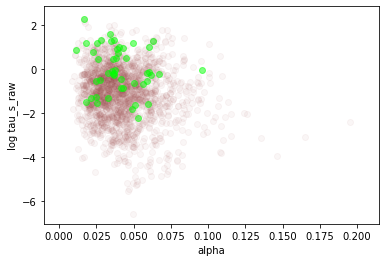

In [11]:
run_all('2')

In [ ]:
run_all('3')

[10000, 4, 9000, 0.99]
Reusing model.


### Reproduce results without SurvivalStan

In [ ]:
run3 = infer_params(Niter = 5000, Nchains = 4, Nwarmup = 4500, Nadapt_delta = 0.9999)

survivalstan.utils.filter_stan_summary([run3], pars=['lp__', 'alpha', 'beta', 'tau_s_raw', 'tau_raw'])

pystan.check_hmc_diagnostics(run3['fit'])

div_trans_beta(run3['fit'])
div_trans_tau_s(run3['fit'])

## More flexible baseline hazards: Piecewise hazard

One of the more critical parameterizations to get right is that of the baseline hazard. The baseline hazard behaves like an intercept in a typical regression model. It describes the instantaneous hazard over time for the population in the absence of any covariate effects. Failure to get this right can lead to all sorts of pathologies whereby the excess variation in hazard not accounted for by your modeled baseline hazard will be absorbed into covariate effects, yielding invalid inferences and potentially misleading conclusions.

*Aside: This is not a concern when using a Cox PH model for example, because the coefficient values are estimated using Maximum Likelihood Estimation (MLE) on a partial likelihood which does not include the baseline hazard. In a Bayesian analysis, however, we have the challenge of estimating the hazard as well as the coefficient effects.*

Most of the time, we do not have a prior belief on the distribution of the baseline hazard. We usually do not care that much about what the features of the baseline hazard look like (although perhaps we should!). Instead, we are concerned with making sure our inferences about coefficient values are valid.

We thus want a baseline hazard that is sufficiently flexible to absorb any variation in the hazard over time which should not be attributed to covariate values. We also however want to minimize the risk of overfitting, so that our posterior predicted probabilities of survival are well calibrated. Many of the semi- or non-parametric approaches to modeling baseline hazards are very flexible with a penalty to impose the upper bound of complexity.

Piecewise-Exponential Model: https://data.princeton.edu/wws509/notes/c7s4